In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns
import statistics

2022-10-13 15:35:54.718857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 15:35:54.718914: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
dateparse = lambda x: datetime.strptime(x, '%d-%b-%y')
df = pd.read_csv('../data_priority.csv', parse_dates=['date'], date_parser=dateparse)
df = df.set_index('date')

In [4]:
df1 = df.loc["2015-02-01":"2016-09-01"]
df2 = df.loc["2016-03-01":"2017-09-30"]
df3 = df.loc["2017-09-01":"2019-04-02"]

In [5]:
df1.index[0].strftime('%A'), df2.index[0].strftime('%A'), df3.index[0].strftime('%A')

('Sunday', 'Tuesday', 'Friday')

In [6]:
df1.index[-1].strftime('%A'), df2.index[-1].strftime('%A'), df3.index[-1].strftime('%A')

('Thursday', 'Saturday', 'Tuesday')

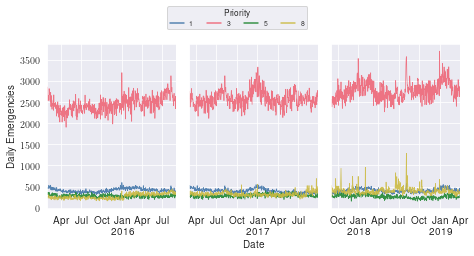

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17*cm, 8*cm), sharey=True)
axes[0].set(ylabel='Daily Emergencies')
df1.pivot_table(values="count",index="date",columns="priority").plot(linewidth=.7, alpha=0.9,color=colors[0:4], legend=None, ax=axes[0], xlabel='')
df2.pivot_table(values="count",index="date",columns="priority").plot(linewidth=.7, alpha=0.9,color=colors[0:4], legend=None, ax=axes[1], xlabel='Date')
df3.pivot_table(values="count",index="date",columns="priority").plot(linewidth=.7, alpha=0.9,color=colors[0:4], legend=None, ax=axes[2], xlabel='')
leg = fig.legend([1,3,5,8], title='Priority', title_fontsize='small', fontsize='x-small', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)    
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
plt.tight_layout()
plt.savefig('figures/emergencies_daily_priority.pdf', bbox_inches = "tight")

### Create batches of training data (12 months)

In [8]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [9]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=250, batch_size=64, callbacks=[callback])
    
    loss_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
    return model 

In [10]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 7, 7, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)
    
    x_input = dataset[-n_steps_in:]
    x_input = x_input.reshape((1, n_input, 1))
    pred = model.predict(x_input).reshape(-1, 1)
    pred = scaler.inverse_transform(pred)
    #print(x_input,pred)
    
    mae, rmse, smape = list(), list(), list()  
    for i in range(0, len(test), n_steps_in):
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(actual[i:i+n_steps_in], pred, mae, rmse, smape)
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        #print(x_input, current_pred)
    
    return mae, rmse, smape

In [11]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [12]:
def measure_error(actual, pred, step, index):
    #print(actual[index:index+step], pred)
    mae = mean_absolute_error(array(actual[index:index+step]), pred)
    rmse = np.sqrt(mean_squared_error(array(actual[index:index+step]), pred))
    smape = sMAPE(array(actual[index:index+step]), pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

[0.5314685  0.48374605 0.645      0.4055944  0.56643355 0.7383901
 0.92999995 0.29720283 0.5174825  0.5046439  0.71000004 0.26923078
 0.576923   0.49380803 0.68499994 0.22377622 0.527972   0.5379256
 0.91499996 0.23076928 0.513986   0.58746135 0.765      0.43706298
 0.7202797  0.56965935 0.35000002 0.5174826 ] [0.51506376 0.6993048  0.55851674 0.5979142  0.580533   0.5590961
 0.4855156 ] 28 7


2022-10-13 15:36:00.653734: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-13 15:36:00.653776: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-13 15:36:00.654305: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/250
8/8 [==============================] - 2s 16ms/step - loss: 0.1466
Epoch 2/250
8/8 [==============================] - 0s 14ms/step - loss: 0.1224
Epoch 3/250
8/8 [==============================] - 0s 14ms/step - loss: 0.0940
Epoch 4/250
8/8 [==============================] - 0s 13ms/step - loss: 0.0494
Epoch 5/250
8/8 [==============================] - 0s 16ms/step - loss: 0.0262
Epoch 6/250
8/8 [==============================] - 0s 18ms/step - loss: 0.0181
Epoch 7/250
8/8 [==============================] - 0s 20ms/step - loss: 0.0141
Epoch 8/250
8/8 [==============================] - 0s 18ms/step - loss: 0.0125
Epoch 9/250
8/8 [==============================] - 0s 16ms/step - loss: 0.0121
Epoch 10/250
8/8 [==============================] - 0s 17ms/step - loss: 0.0120
Epoch 11/250
8/8 [==============================] - 0s 16ms/step - loss: 0.0118
Epoch 12/250
8/8 [==============================] - 0s 17ms/step - loss: 0.0117
Epoch 13/250
8/8 [==============================]

8/8 [==============================] - 0s 17ms/step - loss: 0.0111
Epoch 104/250
8/8 [==============================] - 0s 24ms/step - loss: 0.0111
Epoch 105/250
8/8 [==============================] - 0s 22ms/step - loss: 0.0111
Epoch 106/250
8/8 [==============================] - 0s 17ms/step - loss: 0.0111
Epoch 107/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0111
Epoch 108/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0113
Epoch 109/250
8/8 [==============================] - 0s 22ms/step - loss: 0.0111
Epoch 110/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0112
Epoch 111/250
8/8 [==============================] - 0s 24ms/step - loss: 0.0111
Epoch 112/250
8/8 [==============================] - 0s 17ms/step - loss: 0.0111
Epoch 113/250
8/8 [==============================] - 0s 16ms/step - loss: 0.0110
Epoch 114/250
8/8 [==============================] - 0s 18ms/step - loss: 0.0111
Epoch 115/250
8/8 [=======================

8/8 [==============================] - 0s 27ms/step - loss: 0.0109
Epoch 205/250
8/8 [==============================] - 0s 17ms/step - loss: 0.0109
Epoch 206/250
8/8 [==============================] - 0s 17ms/step - loss: 0.0110
Epoch 207/250
8/8 [==============================] - 0s 17ms/step - loss: 0.0108
Epoch 208/250
8/8 [==============================] - 0s 26ms/step - loss: 0.0110
Epoch 209/250
8/8 [==============================] - 0s 18ms/step - loss: 0.0109
Epoch 210/250
8/8 [==============================] - 0s 17ms/step - loss: 0.0108
Epoch 211/250
8/8 [==============================] - 0s 19ms/step - loss: 0.0108
Epoch 212/250
8/8 [==============================] - 0s 17ms/step - loss: 0.0108
Epoch 213/250
8/8 [==============================] - 0s 17ms/step - loss: 0.0109
Epoch 214/250
8/8 [==============================] - 0s 18ms/step - loss: 0.0110
Epoch 215/250
8/8 [==============================] - 0s 20ms/step - loss: 0.0109
Epoch 216/250
8/8 [=======================

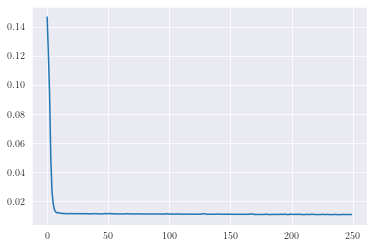

In [13]:
df1 = df1.pivot_table('count', 'date', 'priority')
df1['Total'] = df1.sum(axis=1)
dataset = df1[[1,3,5,8]].values
dataset = df1[[1,3,5,8]].astype('float32')
dataset_total = df1[['Total']].values
dataset_total = df1[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae1, rmse1, smape1 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df1[['Total']][509:].values)

[0.740458   0.53047776 0.36492896 0.14110428 0.93129766 0.39456344
 0.36966825 0.2658487  0.851145   0.38797355 0.36966825 0.30470347
 0.610687   0.3434925  0.40758288 0.400818   0.629771   0.22075784
 0.3270142  0.204499   0.8816793  0.25535417 0.19431281 0.21267891
 0.7633587  0.48270178 0.69668245 0.23312885] [0.48509824 0.36651862 0.4863664  0.5814837  0.43563735 0.46670902
 0.58845913] 28 7
Epoch 1/250
8/8 [==============================] - 3s 29ms/step - loss: 0.1462
Epoch 2/250
8/8 [==============================] - 0s 30ms/step - loss: 0.1204
Epoch 3/250
8/8 [==============================] - 0s 26ms/step - loss: 0.0852
Epoch 4/250
8/8 [==============================] - 0s 24ms/step - loss: 0.0525
Epoch 5/250
8/8 [==============================] - 0s 24ms/step - loss: 0.0268
Epoch 6/250
8/8 [==============================] - 0s 26ms/step - loss: 0.0202
Epoch 7/250
8/8 [==============================] - 0s 26ms/step - loss: 0.0192
Epoch 8/250
8/8 [==============================]

8/8 [==============================] - 0s 26ms/step - loss: 0.0180
Epoch 99/250
8/8 [==============================] - 0s 28ms/step - loss: 0.0180
Epoch 100/250
8/8 [==============================] - 0s 28ms/step - loss: 0.0181
Epoch 101/250
8/8 [==============================] - 0s 24ms/step - loss: 0.0181
Epoch 102/250
8/8 [==============================] - 0s 25ms/step - loss: 0.0179
Epoch 103/250
8/8 [==============================] - 0s 26ms/step - loss: 0.0178
Epoch 104/250
8/8 [==============================] - 0s 26ms/step - loss: 0.0178
Epoch 105/250
8/8 [==============================] - 0s 32ms/step - loss: 0.0179
Epoch 106/250
8/8 [==============================] - 0s 27ms/step - loss: 0.0182
Epoch 107/250
8/8 [==============================] - 0s 34ms/step - loss: 0.0182
Epoch 108/250
8/8 [==============================] - 0s 33ms/step - loss: 0.0181
Epoch 109/250
8/8 [==============================] - 0s 30ms/step - loss: 0.0178
Epoch 110/250
8/8 [========================

8/8 [==============================] - 0s 29ms/step - loss: 0.0177
Epoch 200/250
8/8 [==============================] - 0s 34ms/step - loss: 0.0179
Epoch 201/250
8/8 [==============================] - 0s 38ms/step - loss: 0.0177
Epoch 202/250
8/8 [==============================] - 0s 42ms/step - loss: 0.0177
Epoch 203/250
8/8 [==============================] - 0s 44ms/step - loss: 0.0176
Epoch 204/250
8/8 [==============================] - 0s 42ms/step - loss: 0.0176
Epoch 205/250
8/8 [==============================] - 0s 29ms/step - loss: 0.0177
Epoch 206/250
8/8 [==============================] - 0s 33ms/step - loss: 0.0176
Epoch 207/250
8/8 [==============================] - 0s 29ms/step - loss: 0.0176
Epoch 208/250
8/8 [==============================] - 0s 27ms/step - loss: 0.0176
Epoch 209/250
8/8 [==============================] - 0s 27ms/step - loss: 0.0176
Epoch 210/250
8/8 [==============================] - 0s 25ms/step - loss: 0.0176
Epoch 211/250
8/8 [=======================

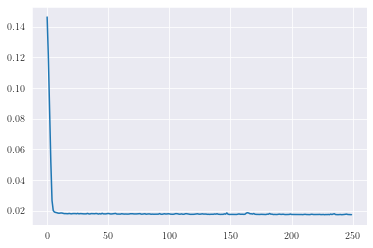

In [14]:
df2 = df2.pivot_table('count', 'date', 'priority')
df2['Total'] = df2.sum(axis=1)
dataset = df2[[1,3,5,8]].values
dataset = df2[[1,3,5,8]].astype('float32')
dataset_total = df2[['Total']].values
dataset_total = df2[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae2, rmse2, smape2 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df2[['Total']][509:].values)

[0.19540226 0.09255397 0.6355933  0.08806261 0.21072793 0.19832993
 0.4364407  0.25636008 0.11111104 0.1530968  0.40254235 0.11448142
 0.16091943 0.20876837 0.77966106 0.10665363 0.1302681  0.08350742
 0.5127119  0.02054796 0.01149416 0.2560891  0.60169494 0.14774951
 0.15708804 0.21503139 0.6228814  0.15851271] [0.18167579 0.13508224 0.13312447 0.16875482 0.1041503  0.13077521
 0.10297573] 28 7
Epoch 1/250
8/8 [==============================] - 2s 20ms/step - loss: 0.0790
Epoch 2/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0589
Epoch 3/250
8/8 [==============================] - 0s 22ms/step - loss: 0.0392
Epoch 4/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0211
Epoch 5/250
8/8 [==============================] - 0s 20ms/step - loss: 0.0152
Epoch 6/250
8/8 [==============================] - 0s 25ms/step - loss: 0.0127
Epoch 7/250
8/8 [==============================] - 0s 24ms/step - loss: 0.0121
Epoch 8/250
8/8 [==============================]

8/8 [==============================] - 0s 21ms/step - loss: 0.0111
Epoch 99/250
8/8 [==============================] - 0s 20ms/step - loss: 0.0111
Epoch 100/250
8/8 [==============================] - 0s 20ms/step - loss: 0.0111
Epoch 101/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0111
Epoch 102/250
8/8 [==============================] - 0s 22ms/step - loss: 0.0113
Epoch 103/250
8/8 [==============================] - 0s 20ms/step - loss: 0.0112
Epoch 104/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0112
Epoch 105/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0112
Epoch 106/250
8/8 [==============================] - 0s 22ms/step - loss: 0.0111
Epoch 107/250
8/8 [==============================] - 0s 22ms/step - loss: 0.0112
Epoch 108/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0111
Epoch 109/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0111
Epoch 110/250
8/8 [========================

8/8 [==============================] - 0s 21ms/step - loss: 0.0106
Epoch 200/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0106
Epoch 201/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0106
Epoch 202/250
8/8 [==============================] - 0s 20ms/step - loss: 0.0106
Epoch 203/250
8/8 [==============================] - 0s 22ms/step - loss: 0.0106
Epoch 204/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0107
Epoch 205/250
8/8 [==============================] - 0s 22ms/step - loss: 0.0107
Epoch 206/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0108
Epoch 207/250
8/8 [==============================] - 0s 20ms/step - loss: 0.0107
Epoch 208/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0107
Epoch 209/250
8/8 [==============================] - 0s 22ms/step - loss: 0.0107
Epoch 210/250
8/8 [==============================] - 0s 20ms/step - loss: 0.0106
Epoch 211/250
8/8 [=======================

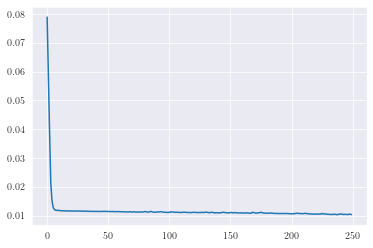

In [15]:
df3 = df3.pivot_table('count', 'date', 'priority')
df3['Total'] = df3.sum(axis=1)
dataset = df3[[1,3,5,8]].values
dataset = df3[[1,3,5,8]].astype('float32')
dataset_total = df3[['Total']].values
dataset_total = df3[['Total']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_total = scaler.fit_transform(dataset_total)
mae3, rmse3, smape3 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df3[['Total']][509:].values)

In [16]:
mae = mae1 + mae2 + mae3
rmse = rmse1 + rmse2 + rmse3
smape = smape1 + smape2 + smape3

### Calculate Error

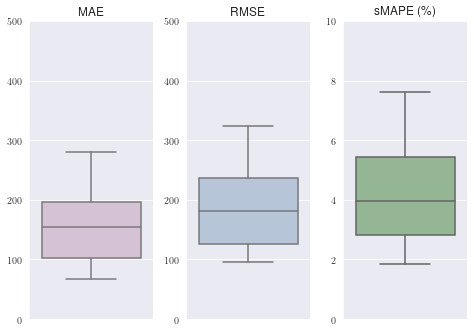

In [17]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 500))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 500))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
#plt.savefig('figures/emergencies_lstm_daily_priority_boxplot.pdf')

In [19]:
emer_lstm_day_priority = [mae,rmse,smape]
%store emer_lstm_day_priority

Stored 'emer_lstm_day_priority' (list)
